# Part 3: Feature Improvement and Model Testing

In this notebook I will reorganize the content from the past few notebooks to provide a cleaner and more concise view of my project. I will then look at feature importance, adding a new feature and start looking into the use of ensemble learning to further improve the model.

In [1]:
#Importing Necessary Libraries

from sportsipy.nfl.boxscore import Boxscores
from sportsipy.nfl.schedule import Schedule, Game
from sportsipy.nfl.teams import Teams, Team

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Reading in the initial schedule that includes all stats from every game

combined_schedule = pd.read_csv('combined_schedule.csv')
combined_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25612 entries, 0 to 25611
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   boxscore_index           25612 non-null  object 
 1   date                     25612 non-null  object 
 2   datetime                 25612 non-null  object 
 3   day                      25612 non-null  object 
 4   extra_points_attempted   25612 non-null  int64  
 5   extra_points_made        25612 non-null  int64  
 6   field_goals_attempted    25612 non-null  int64  
 7   field_goals_made         25612 non-null  int64  
 8   fourth_down_attempts     16573 non-null  float64
 9   fourth_down_conversions  16573 non-null  float64
 10  interceptions            25612 non-null  int64  
 11  location                 25612 non-null  object 
 12  opponent_abbr            25612 non-null  object 
 13  opponent_name            25612 non-null  object 
 14  overtime              

In [3]:
#Dropping columns that will not be relevant features. 

combined_schedule = combined_schedule.drop(['date','overtime','datetime','day','opponent_name','boxscore_index', 'location', 'opponent_abbr','pass_attempts','pass_completions','pass_yards','rush_attempts', 'rush_yards','punt_yards'], axis =1)

In [4]:
combined_schedule['time_of_possession']

0        34:25
1        23:41
2        29:43
3        30:32
4        28:44
         ...  
25607    27:51
25608    31:25
25609    26:27
25610    36:08
25611    27:00
Name: time_of_possession, Length: 25612, dtype: object

In [5]:
# Converting the time of possesion values to an integer
from datetime import datetime


def convert_to_seconds(time_str):
    if isinstance(time_str, str):
        time_obj = datetime.strptime(time_str, '%M:%S')
        total_seconds = time_obj.minute * 60 + time_obj.second
        return total_seconds
    else:
        return 0

combined_schedule['time_of_possession'] = combined_schedule['time_of_possession'].apply(convert_to_seconds)

print(combined_schedule['time_of_possession'])


0        2065
1        1421
2        1783
3        1832
4        1724
         ... 
25607    1671
25608    1885
25609    1587
25610    2168
25611    1620
Name: time_of_possession, Length: 25612, dtype: int64


In [6]:
# Feature reduction by combining features into ratios
# Implementing try - except to replace any null values with 0's
try:
    combined_schedule['extra_points_ratio'] = combined_schedule['extra_points_made'] / combined_schedule['extra_points_attempted']
except ZeroDivisionError:
    combined_schedule['extra_points_ratio'] = 0
combined_schedule['extra_points_ratio'] = combined_schedule['extra_points_ratio'].fillna(0)

try:
    combined_schedule['field_goal_ratio'] = combined_schedule['field_goals_made'] / combined_schedule['field_goals_attempted']
except ZeroDivisionError:
    combined_schedule['field_goal_ratio'] = 0
combined_schedule['field_goal_ratio'] = combined_schedule['field_goal_ratio'].fillna(0)
    
try:    
    combined_schedule['fourth_down_ratio'] = combined_schedule['fourth_down_conversions'] / combined_schedule['fourth_down_attempts']
except ZeroDivisionError:
    combined_schedule['fourth_down_ratio'] = 0
combined_schedule['fourth_down_ratio'] = combined_schedule['fourth_down_ratio'].fillna(0)

try:
    combined_schedule['third_down_ratio'] = combined_schedule['third_down_conversions'] / combined_schedule['third_down_attempts']
except ZeroDivisionError:
    combined_schedule['third_down_ratio'] = 0
combined_schedule['third_down_ratio'] = combined_schedule['third_down_ratio'].fillna(0)
  

combined_schedule = combined_schedule.drop(['extra_points_attempted', 'extra_points_made','field_goals_made', 'field_goals_attempted', 'fourth_down_conversions', 'fourth_down_attempts','third_down_conversions', 'third_down_attempts'], axis=1)

combined_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25612 entries, 0 to 25611
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   interceptions           25612 non-null  int64  
 1   pass_completion_rate    25612 non-null  float64
 2   pass_touchdowns         25612 non-null  int64  
 3   pass_yards_per_attempt  25612 non-null  float64
 4   points_allowed          25612 non-null  int64  
 5   points_scored           25612 non-null  int64  
 6   punts                   25612 non-null  int64  
 7   quarterback_rating      25612 non-null  float64
 8   result                  25612 non-null  object 
 9   rush_touchdowns         25612 non-null  int64  
 10  rush_yards_per_attempt  25612 non-null  float64
 11  time_of_possession      25612 non-null  int64  
 12  times_sacked            25612 non-null  int64  
 13  type                    25612 non-null  object 
 14  week                    25612 non-null

In [7]:
#Mapping wins to 1 and losses to 0
combined_schedule['result'] = combined_schedule['result'].map({'Loss':0,'Win':1})
print(combined_schedule['result'])

0        1.0
1        0.0
2        1.0
3        1.0
4        0.0
        ... 
25607    1.0
25608    1.0
25609    0.0
25610    1.0
25611    1.0
Name: result, Length: 25612, dtype: float64


In [8]:
#replaces ties with 0.5
combined_schedule['result'].fillna(0.5, inplace=True)
combined_schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25612 entries, 0 to 25611
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   interceptions           25612 non-null  int64  
 1   pass_completion_rate    25612 non-null  float64
 2   pass_touchdowns         25612 non-null  int64  
 3   pass_yards_per_attempt  25612 non-null  float64
 4   points_allowed          25612 non-null  int64  
 5   points_scored           25612 non-null  int64  
 6   punts                   25612 non-null  int64  
 7   quarterback_rating      25612 non-null  float64
 8   result                  25612 non-null  float64
 9   rush_touchdowns         25612 non-null  int64  
 10  rush_yards_per_attempt  25612 non-null  float64
 11  time_of_possession      25612 non-null  int64  
 12  times_sacked            25612 non-null  int64  
 13  type                    25612 non-null  object 
 14  week                    25612 non-null

In [9]:
# Defines an agg function where the inputs are are a dataframe, a week and a year.
# The function's goal is to take the combined schedule and aggregate data according to the week and year.

def agg_weekly_data(df, week, year):
    
    filtered_df = df[(df['week'] < week) & (df['year'] == year)]
    agg_df = filtered_df.groupby('team_abbr').agg({
        'interceptions': 'mean',
        'pass_completion_rate': 'mean',
        'pass_touchdowns': 'mean',
        'pass_yards_per_attempt': 'mean',
        'points_allowed': 'mean',
        'points_scored': 'mean',
        'punts': 'mean',
        'quarterback_rating': 'mean',
        'result': 'mean', #essentially creating a win ratio
        'rush_touchdowns': 'mean',
        'rush_yards_per_attempt': 'mean',
        'time_of_possession': 'mean',
        'times_sacked': 'mean',
        'yards_lost_from_sacks': 'mean',
        'extra_points_ratio': 'mean', 
        'field_goal_ratio': 'mean',
        'fourth_down_ratio': 'mean',
        'third_down_ratio': 'mean',
        'type': 'nunique' # a simple method to know whether the game was a playoff game or not (reg = 1, playoff = 2)
    }).reset_index()
    
    # Renaming the columns
    
    agg_df = agg_df.rename(columns={
        'interceptions': 'avg_interceptions_thrown',
        'pass_completion_rate':'avg_pass_completion_rate',
        'pass_touchdowns': 'avg_pass_touchdowns',
        'pass_yards_per_attempt': 'avg_pass_yards_per_attempt',
        'points_allowed': 'avg_points_allowed',
        'points_scored': 'avg_points_scored',
        'punts': 'avg_punts',
        'quarterback_rating': 'avg_quarterback_rating',
        'result': 'win_ratio', 
        'rush_touchdowns': 'avg_rush_touchdowns',
        'rush_yards_per_attempt': 'avg_rush_yards_per_attempt',
        'time_of_possession': 'avg_time_of_possession',
        'times_sacked': 'avg_times_sacked',
        'yards_lost_from_sacks': 'avg_yards_lost_from_sacks',
        'extra_points_ratio': 'avg_extra_points_ratio', 
        'field_goal_ratio': 'avg_field_goal_ratio',
        'fourth_down_ratio': 'avg_fourth_down_ratio',
        'third_down_ratio': 'avg_third_down_ratio'
     })
    
    # Preserving the week and year that is being aggregated to for the use of a later join
    agg_df['week'] = week
    agg_df['year'] = year
    
    return agg_df

In [10]:
agg_weekly_data(combined_schedule,20,2022)

,team_abbr,avg_interceptions_thrown,avg_pass_completion_rate,avg_pass_touchdowns,avg_pass_yards_per_attempt,avg_points_allowed,avg_points_scored,avg_punts,avg_quarterback_rating,win_ratio,...,avg_time_of_possession,avg_times_sacked,avg_yards_lost_from_sacks,avg_extra_points_ratio,avg_field_goal_ratio,avg_fourth_down_ratio,avg_third_down_ratio,type,week,year
0,atl,0.529412,62.200000,1.000000,7.241176,22.705882,21.470588,3.647059,86.335294,0.411765,...,1802.000000,2.176471,13.411765,0.882353,0.792157,0.308824,0.410852,1,20,2022
1,buf,0.941176,62.329412,2.235294,7.600000,18.647059,28.764706,3.000000,93.241176,0.823529,...,1799.764706,2.352941,11.647059,0.965686,0.794118,0.215686,0.499455,2,20,2022
2,car,0.764706,58.070588,0.941176,7.064706,22.000000,20.411765,4.764706,78.582353,0.411765,...,1712.882353,2.117647,14.705882,0.833333,0.848039,0.378431,0.311424,1,20,2022
3,chi,0.882353,58.864706,1.117647,6.941176,27.235294,19.176471,3.941176,75.023529,0.176471,...,1770.764706,3.411765,22.294118,0.838235,0.715686,0.196078,0.391059,1,20,2022
4,cin,0.705882,68.788235,2.117647,7.394118,19.941176,26.000000,3.647059,99.629412,0.764706,...,1918.764706,2.823529,18.000000,0.774510,0.754902,0.137255,0.470935,2,20,2022
5,cle,0.705882,62.505882,1.117647,7.094118,22.411765,21.235294,3.588235,83.570588,0.411765,...,1909.235294,2.588235,15.647059,0.906863,0.745098,0.455882,0.382767,1,20,2022
6,clt,1.176471,65.470588,1.000000,6.358824,25.117647,17.000000,4.176471,75.158824,0.264706,...,1837.941176,3.529412,24.823529,0.764706,0.769608,0.289216,0.322909,1,20,2022
7,crd,1.000000,65.582353,1.000000,6.047059,26.411765,20.000000,4.000000,78.023529,0.235294,...,1814.117647,2.705882,20.000000,0.774510,0.674510,0.385294,0.351689,1,20,2022
8,dal,1.000000,65.500000,1.777778,7.327778,19.777778,27.666667,4.000000,91.777778,0.722222,...,1794.388889,1.555556,10.166667,0.808730,0.625000,0.383333,0.462337,2,20,2022
9,den,0.882353,61.205882,1.058824,7.258824,21.117647,16.882353,5.647059,80.988235,0.294118,...,1796.529412,3.705882,24.411765,0.686275,0.705882,0.352941,0.288596,1,20,2022


In [11]:
#Nested for statements to combine the agg_weekly_data function for each week of each season

complete_agg_weekly_data = pd.DataFrame()
years = range(1970, 2023)  

for year in years:
    for week in range(2, 24):
        agg_data = agg_weekly_data(combined_schedule, week, year)
        complete_agg_weekly_data = complete_agg_weekly_data.append(agg_data, ignore_index=True)


In [12]:
complete_agg_weekly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34534 entries, 0 to 34533
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   team_abbr                   34534 non-null  object 
 1   avg_interceptions_thrown    34534 non-null  float64
 2   avg_pass_completion_rate    34534 non-null  float64
 3   avg_pass_touchdowns         34534 non-null  float64
 4   avg_pass_yards_per_attempt  34534 non-null  float64
 5   avg_points_allowed          34534 non-null  float64
 6   avg_points_scored           34534 non-null  float64
 7   avg_punts                   34534 non-null  float64
 8   avg_quarterback_rating      34534 non-null  float64
 9   win_ratio                   34534 non-null  float64
 10  avg_rush_touchdowns         34534 non-null  float64
 11  avg_rush_yards_per_attempt  34534 non-null  float64
 12  avg_time_of_possession      34534 non-null  float64
 13  avg_times_sacked            345

In [13]:
# casting these columns as strings so that I can use pd.merge after

complete_agg_weekly_data['week'] =complete_agg_weekly_data['week'].astype(str)
complete_agg_weekly_data['year'] =complete_agg_weekly_data['year'].astype(str)

In [14]:
# Sanity check. This shows the data from all week 7 games across all years

complete_agg_weekly_data[complete_agg_weekly_data['week'] == '7']

,team_abbr,avg_interceptions_thrown,avg_pass_completion_rate,avg_pass_touchdowns,avg_pass_yards_per_attempt,avg_points_allowed,avg_points_scored,avg_punts,avg_quarterback_rating,win_ratio,...,avg_time_of_possession,avg_times_sacked,avg_yards_lost_from_sacks,avg_extra_points_ratio,avg_field_goal_ratio,avg_fourth_down_ratio,avg_third_down_ratio,type,week,year
130,atl,1.500000,58.333333,1.333333,6.150000,16.833333,16.833333,5.166667,70.016667,0.500000,...,0.000000,2.833333,23.833333,0.750000,0.375000,0.000000,0.000000,1,7,1970
131,buf,2.166667,53.000000,0.666667,8.200000,22.833333,13.000000,6.000000,50.350000,0.333333,...,0.000000,4.500000,45.833333,0.833333,0.472222,0.000000,0.000000,1,7,1970
132,chi,1.666667,53.750000,1.000000,5.600000,20.000000,12.500000,5.833333,58.800000,0.333333,...,0.000000,1.833333,14.666667,0.833333,0.277778,0.000000,0.000000,1,7,1970
133,cin,1.166667,50.266667,0.666667,6.150000,26.000000,15.500000,6.000000,55.966667,0.166667,...,0.000000,3.166667,23.000000,0.666667,0.511111,0.000000,0.000000,1,7,1970
134,cle,1.833333,49.383333,1.500000,7.833333,21.666667,26.500000,5.000000,71.166667,0.666667,...,0.000000,0.833333,8.333333,0.916667,0.416667,0.000000,0.000000,1,7,1970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34017,sdg,0.500000,66.616667,1.666667,6.900000,25.333333,23.500000,3.833333,95.666667,0.666667,...,1881.333333,1.166667,6.000000,1.000000,0.916667,0.305556,0.404281,1,7,2022
34018,sea,0.500000,72.900000,1.500000,8.100000,27.166667,24.333333,3.333333,104.000000,0.500000,...,1645.666667,2.333333,18.666667,0.944444,0.777778,0.111111,0.417901,1,7,2022
34019,sfo,0.666667,60.166667,1.166667,7.566667,14.833333,20.333333,3.833333,86.933333,0.500000,...,1796.333333,1.500000,8.333333,0.966667,0.611111,0.111111,0.390931,1,7,2022
34020,tam,0.166667,66.366667,1.333333,6.716667,17.166667,20.166667,4.500000,92.133333,0.500000,...,1698.000000,1.500000,10.833333,0.666667,0.966667,0.333333,0.380215,1,7,2022


In [15]:
schedule_df = pd.read_csv('combined_games.csv')

In [16]:
schedule_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12435 entries, 0 to 12434
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   week          12435 non-null  object
 1   away_abbr     12435 non-null  object
 2   home_abbr     12435 non-null  object
 3   winning_abbr  12379 non-null  object
dtypes: object(4)
memory usage: 388.7+ KB


In [17]:
#Using string split to obtain a year and week columns. This allows for the schedule_df to be merged with complete_agg_weekly_data

schedule_df['week'], schedule_df['year'] = schedule_df['week'].str.split('-', 1).str
schedule_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12435 entries, 0 to 12434
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   week          12435 non-null  object
 1   away_abbr     12435 non-null  object
 2   home_abbr     12435 non-null  object
 3   winning_abbr  12379 non-null  object
 4   year          12435 non-null  object
dtypes: object(5)
memory usage: 485.9+ KB


/var/folders/_3/qqy7kcyd26z35my2nt36j9ym0000gn/T/ipykernel_74318/2733547539.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  schedule_df['week'], schedule_df['year'] = schedule_df['week'].str.split('-', 1).str


In [18]:
#Creating a df for the home and away teams by merging the game data with the schedule using the week, year and team_abbrs

home_df = pd.merge(schedule_df,complete_agg_weekly_data, left_on = ['week','year','home_abbr'], right_on=['week','year','team_abbr'])

#Sanity check to ensure that both dataframes are the same size and have no duplicates
print(home_df.duplicated().sum())
print(home_df.shape)
print(schedule_df.shape)

away_df = pd.merge(schedule_df,complete_agg_weekly_data, left_on = ['week','year','away_abbr'], right_on=['week','year','team_abbr'])
print(away_df.duplicated().sum())
print(away_df.shape)
print(schedule_df.shape)


0
(11654, 25)
(12435, 5)
0
(11654, 25)
(12435, 5)


In [19]:
#Adjusting settings so that all columns can be seen

pd.set_option('display.max_columns', None)

home_df

,week,away_abbr,home_abbr,winning_abbr,year,team_abbr,avg_interceptions_thrown,avg_pass_completion_rate,avg_pass_touchdowns,avg_pass_yards_per_attempt,avg_points_allowed,avg_points_scored,avg_punts,avg_quarterback_rating,win_ratio,avg_rush_touchdowns,avg_rush_yards_per_attempt,avg_time_of_possession,avg_times_sacked,avg_yards_lost_from_sacks,avg_extra_points_ratio,avg_field_goal_ratio,avg_fourth_down_ratio,avg_third_down_ratio,type
0,2,gnb,car,gnb,2011,car,1.000000,64.900000,2.000000,11.400000,28.000000,21.000000,7.000000,108.300000,0.000000,1.000000,2.700000,1967.000000,4.000000,19.000000,1.000000,0.000000,0.000000,0.272727,1
1,2,cle,clt,cle,2011,clt,0.000000,51.600000,1.000000,6.400000,34.000000,7.000000,6.000000,79.000000,0.000000,0.000000,4.000000,1396.000000,3.000000,25.000000,1.000000,0.000000,0.000000,0.111111,1
2,2,kan,det,det,2011,det,1.000000,72.700000,3.000000,9.200000,20.000000,27.000000,5.000000,118.900000,1.000000,0.000000,3.600000,2185.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.181818,1
3,2,chi,nor,nor,2011,nor,0.000000,65.300000,3.000000,8.600000,42.000000,34.000000,2.000000,110.600000,0.000000,0.000000,3.900000,1626.000000,3.000000,23.000000,1.000000,1.000000,0.000000,0.642857,1
4,2,jax,nyj,nyj,2011,nyj,1.000000,59.100000,2.000000,7.600000,24.000000,27.000000,6.000000,86.800000,1.000000,0.000000,2.800000,1567.000000,4.000000,20.000000,1.000000,1.000000,0.000000,0.428571,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11649,19,rav,buf,buf,2020,buf,0.647059,68.900000,2.470588,8.170588,23.470588,31.058824,2.647059,106.129412,0.823529,1.000000,4.182353,1884.117647,1.705882,11.117647,0.906863,0.794118,0.274510,0.469010,2
11650,19,cle,kan,kan,2020,kan,0.437500,67.287500,2.500000,8.006250,22.625000,29.562500,3.250000,106.737500,0.875000,0.812500,4.362500,1831.437500,1.500000,9.437500,0.855208,0.729167,0.395833,0.478420,1
11651,19,tam,nor,tam,2020,nor,0.470588,70.388235,1.764706,7.547059,20.352941,29.588235,3.823529,100.294118,0.764706,1.823529,4.529412,1954.588235,1.764706,11.176471,0.985294,0.664706,0.460784,0.454825,2
11652,20,tam,gnb,tam,2020,gnb,0.294118,70.729412,2.941176,8.217647,22.764706,31.823529,2.882353,117.476471,0.823529,1.058824,4.711765,1967.411765,1.235294,11.352941,0.949020,0.705882,0.388235,0.509901,2


In [20]:
away_df

,week,away_abbr,home_abbr,winning_abbr,year,team_abbr,avg_interceptions_thrown,avg_pass_completion_rate,avg_pass_touchdowns,avg_pass_yards_per_attempt,avg_points_allowed,avg_points_scored,avg_punts,avg_quarterback_rating,win_ratio,avg_rush_touchdowns,avg_rush_yards_per_attempt,avg_time_of_possession,avg_times_sacked,avg_yards_lost_from_sacks,avg_extra_points_ratio,avg_field_goal_ratio,avg_fourth_down_ratio,avg_third_down_ratio,type
0,2,gnb,car,gnb,2011,gnb,0.000000,77.100000,3.000000,8.900000,34.000000,42.000000,4.000000,130.200000,1.000000,2.000000,3.800000,1974.000000,2.000000,16.000000,1.000000,0.000000,0.000000,0.666667,1
1,2,cle,clt,cle,2011,cle,1.000000,47.500000,2.000000,5.300000,27.000000,17.000000,8.000000,69.000000,0.000000,0.000000,3.200000,1777.000000,2.000000,11.000000,1.000000,1.000000,0.500000,0.266667,1
2,2,kan,det,det,2011,kan,1.000000,61.100000,1.000000,3.300000,41.000000,7.000000,8.000000,63.200000,0.000000,0.000000,6.000000,1378.000000,2.000000,14.000000,1.000000,0.000000,0.000000,0.230769,1
3,2,chi,nor,nor,2011,chi,1.000000,68.800000,2.000000,9.800000,12.000000,30.000000,6.000000,104.800000,1.000000,0.000000,3.300000,1999.000000,5.000000,23.000000,1.000000,1.000000,0.000000,0.375000,1
4,2,jax,nyj,nyj,2011,jax,0.000000,70.800000,0.000000,7.300000,14.000000,16.000000,5.000000,88.900000,1.000000,1.000000,3.500000,2378.000000,2.000000,15.000000,1.000000,1.000000,0.000000,0.500000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11649,19,rav,buf,buf,2020,rav,0.705882,64.023529,1.588235,7.264706,18.588235,28.705882,3.235294,92.241176,0.705882,1.529412,5.552941,1897.529412,2.176471,11.411765,0.988235,0.852941,0.460784,0.489521,2
11650,19,cle,kan,kan,2020,cle,0.470588,63.247059,1.764706,7.541176,26.823529,26.823529,3.294118,96.394118,0.705882,1.352941,4.617647,1841.058824,1.529412,9.529412,0.809804,0.637255,0.294118,0.451491,2
11651,19,tam,nor,tam,2020,tam,0.705882,64.805882,2.588235,7.711765,22.235294,30.764706,3.411765,101.388235,0.705882,1.000000,4.011765,1742.529412,1.470588,9.764706,0.843978,0.882353,0.411765,0.424163,2
11652,20,tam,gnb,tam,2020,tam,0.666667,64.233333,2.555556,7.616667,22.111111,30.722222,3.444444,100.844444,0.722222,1.000000,3.988889,1750.777778,1.444444,9.777778,0.852646,0.888889,0.444444,0.426742,2


In [21]:
print(home_df.info())
print(away_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11654 entries, 0 to 11653
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   week                        11654 non-null  object 
 1   away_abbr                   11654 non-null  object 
 2   home_abbr                   11654 non-null  object 
 3   winning_abbr                11602 non-null  object 
 4   year                        11654 non-null  object 
 5   team_abbr                   11654 non-null  object 
 6   avg_interceptions_thrown    11654 non-null  float64
 7   avg_pass_completion_rate    11654 non-null  float64
 8   avg_pass_touchdowns         11654 non-null  float64
 9   avg_pass_yards_per_attempt  11654 non-null  float64
 10  avg_points_allowed          11654 non-null  float64
 11  avg_points_scored           11654 non-null  float64
 12  avg_punts                   11654 non-null  float64
 13  avg_quarterback_rating      116

In [22]:
# now that we have merged everything, these cols can be returned to ints
home_df['week'] = home_df['week'].astype(int)
home_df['year'] = home_df['year'].astype(int)
away_df['week'] = away_df['week'].astype(int)
away_df['year'] = away_df['year'].astype(int)


- Let's add a feature that includes a very popular NFL elo rating system and the importance of a QB
- https://github.com/fivethirtyeight/data/tree/master/nfl-elo

In [23]:

nfl_elo = pd.read_csv('nfl_elo.csv')

In [24]:
nfl_elo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            17379 non-null  object 
 1   season          17379 non-null  int64  
 2   neutral         17379 non-null  int64  
 3   playoff         616 non-null    object 
 4   team1           17379 non-null  object 
 5   team2           17379 non-null  object 
 6   elo1_pre        17379 non-null  float64
 7   elo2_pre        17379 non-null  float64
 8   elo_prob1       17379 non-null  float64
 9   elo_prob2       17379 non-null  float64
 10  elo1_post       17379 non-null  float64
 11  elo2_post       17379 non-null  float64
 12  qbelo1_pre      15217 non-null  float64
 13  qbelo2_pre      15217 non-null  float64
 14  qb1             15217 non-null  object 
 15  qb2             15217 non-null  object 
 16  qb1_value_pre   15217 non-null  float64
 17  qb2_value_pre   15217 non-null 

In [25]:
nfl_elo['season'].unique()

array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007,
       2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022])

In [26]:
# Dropping all season data before 1970
nfl_elo = nfl_elo[nfl_elo['season'] > 1969]
nfl_elo['season'].unique()

array([1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [27]:
nfl_elo.sample(10)

,date,season,neutral,playoff,team1,team2,elo1_pre,elo2_pre,elo_prob1,elo_prob2,elo1_post,elo2_post,qbelo1_pre,qbelo2_pre,qb1,qb2,qb1_value_pre,qb2_value_pre,qb1_adj,qb2_adj,qbelo_prob1,qbelo_prob2,qb1_game_value,qb2_game_value,qb1_value_post,qb2_value_post,qbelo1_post,qbelo2_post,score1,score2,quality,importance,total_rating
5991,1977-11-06,1977,0,NaN,NYJ,MIA,1371.044000,1556.380000,0.333431,0.666569,1360.868000,1566.556000,1375.273275,1557.992843,Richard Todd,Bob Griese,77.089877,91.793278,26.801931,-5.373855,0.371175,0.628825,25.182230,159.773077,71.899112,98.591258,1363.791531,1569.474587,10,14,34.0,NaN,NaN
6073,1977-12-18,1977,0,NaN,OAK,KC,1699.224000,1343.597000,0.918439,0.081561,1700.173000,1342.648000,1696.946431,1350.928065,Mike Rae,Tony Adams,24.425257,15.066980,-78.697473,-58.301911,0.901628,0.098372,58.392592,-80.850087,27.821991,5.475273,1698.059345,1349.815151,21,20,19.0,NaN,NaN
14834,2013-11-21,2013,0,NaN,ATL,NO,1440.593000,1627.797000,0.331045,0.668955,1430.498000,1637.892000,1427.051735,1629.962939,Matt Ryan,Drew Brees,176.495150,270.158198,-12.265199,14.687127,0.268995,0.731005,173.771537,211.789994,176.222789,264.321377,1418.941742,1638.072932,13,17,60.0,NaN,NaN
6347,1979-09-09,1979,0,NaN,CHI,MIN,1495.817000,1510.094000,0.572482,0.427518,1520.855000,1485.057000,1494.402020,1512.033293,Mike Phipps,Tommy Kramer,44.698733,48.990909,-4.471632,-9.115144,0.562541,0.437459,-63.653491,63.273081,33.863511,50.419126,1519.744297,1486.691016,26,7,48.0,NaN,NaN
10632,1997-11-23,1997,0,NaN,ATL,NO,1362.256000,1365.751000,0.587600,0.412400,1385.448000,1342.560000,1376.540349,1387.594723,Chris Chandler,Doug Nussmeier,89.717930,43.308831,13.486380,42.025821,0.527382,0.472618,133.090153,-240.652998,94.055152,14.912648,1403.261817,1360.873255,20,3,9.0,NaN,NaN
16644,2020-10-25,2020,0,NaN,ARI,SEA,1515.131968,1624.053372,0.437127,0.562873,1531.056045,1608.129295,1502.957739,1615.701164,Kyler Murray,Russell Wilson,222.969595,242.991619,30.861549,23.973028,0.368689,0.631311,469.677289,333.598998,247.640365,252.052357,1521.237737,1597.421166,37,34,86.0,NaN,NaN
6821,1981-09-20,1981,0,NaN,ATL,SF,1597.692000,1429.339000,0.793030,0.206970,1608.509000,1418.522000,1591.890947,1436.519722,Steve Bartkowski,Joe Montana,110.675247,112.596070,-3.693074,5.136755,0.769806,0.230194,181.629930,183.589784,117.770716,119.695441,1604.182493,1424.228176,34,17,53.0,NaN,NaN
8051,1986-12-07,1986,0,NaN,GB,MIN,1375.937000,1531.383000,0.372700,0.627300,1352.340000,1554.980000,1371.768967,1528.531216,Randy Wright,Tommy Kramer,29.964328,112.975488,4.861079,16.036443,0.344340,0.655660,47.099993,13.567179,31.677895,103.034657,1350.158888,1550.141295,6,32,26.0,NaN,NaN
14915,2013-12-29,2013,0,NaN,TEN,HOU,1437.669000,1334.760000,0.724434,0.275566,1447.633000,1324.796000,1425.700030,1362.729654,Ryan Fitzpatrick,Matt Schaub,130.721162,104.198378,15.369930,1.471280,0.682755,0.317245,16.376910,49.737789,119.286737,98.752319,1437.318318,1351.111366,16,10,7.0,NaN,NaN
17106,2022-09-11,2022,0,NaN,ARI,KC,1501.690031,1628.568000,0.411880,0.588120,1476.226675,1654.031356,1497.994413,1590.288858,Kyler Murray,Patrick Mahomes,187.773068,259.403846,-0.339864,9.404348,0.429777,0.570223,177.226836,491.308820,186.718444,282.594343,1471.273921,1617.009350,21,44,72.0,64.0,68.0


In [28]:
nfl_elo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12830 entries, 4549 to 17378
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            12830 non-null  object 
 1   season          12830 non-null  int64  
 2   neutral         12830 non-null  int64  
 3   playoff         539 non-null    object 
 4   team1           12830 non-null  object 
 5   team2           12830 non-null  object 
 6   elo1_pre        12830 non-null  float64
 7   elo2_pre        12830 non-null  float64
 8   elo_prob1       12830 non-null  float64
 9   elo_prob2       12830 non-null  float64
 10  elo1_post       12830 non-null  float64
 11  elo2_post       12830 non-null  float64
 12  qbelo1_pre      12830 non-null  float64
 13  qbelo2_pre      12830 non-null  float64
 14  qb1             12830 non-null  object 
 15  qb2             12830 non-null  object 
 16  qb1_value_pre   12830 non-null  float64
 17  qb2_value_pre   12830 non-nu

In [29]:
# Retaining the qbelo_prob feature as well as necessary cols for merging

nfl_elo = nfl_elo[['playoff','season','team1', 'team2', 'qbelo_prob1', 'qbelo_prob2']]
nfl_elo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12830 entries, 4549 to 17378
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playoff      539 non-null    object 
 1   season       12830 non-null  int64  
 2   team1        12830 non-null  object 
 3   team2        12830 non-null  object 
 4   qbelo_prob1  12830 non-null  float64
 5   qbelo_prob2  12830 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 701.6+ KB


In [30]:
sorted(nfl_elo['team1'].unique())

['ARI',
 'ATL',
 'BAL',
 'BUF',
 'CAR',
 'CHI',
 'CIN',
 'CLE',
 'DAL',
 'DEN',
 'DET',
 'GB',
 'HOU',
 'IND',
 'JAX',
 'KC',
 'LAC',
 'LAR',
 'MIA',
 'MIN',
 'NE',
 'NO',
 'NYG',
 'NYJ',
 'OAK',
 'PHI',
 'PIT',
 'SEA',
 'SF',
 'TB',
 'TEN',
 'WSH']

In [31]:
sorted(home_df['home_abbr'].unique())

['atl',
 'buf',
 'car',
 'chi',
 'cin',
 'cle',
 'clt',
 'crd',
 'dal',
 'den',
 'det',
 'gnb',
 'htx',
 'jax',
 'kan',
 'mia',
 'min',
 'nor',
 'nwe',
 'nyg',
 'nyj',
 'oti',
 'phi',
 'pit',
 'rai',
 'ram',
 'rav',
 'sdg',
 'sea',
 'sfo',
 'tam',
 'was']

In [32]:
#Adjusting team names from the nfl_elo data to match the home and away dfs
nfl_elo['team1'] = nfl_elo['team1'].str.lower()
nfl_elo['team2'] = nfl_elo['team2'].str.lower()

nfl_elo['team1'] = nfl_elo['team1'].str.replace('oak', 'rai')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('oak', 'rai')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('sf', 'sfo')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('sf', 'sfo')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('tb', 'tam')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('tb', 'tam')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('ten', 'oti')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('ten', 'oti')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('wsh', 'was')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('wsh', 'was')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('ari', 'crd')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('ari', 'crd')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('bal', 'rav')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('bal', 'rav')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('gb', 'gnb')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('gb', 'gnb')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('hou', 'htx')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('hou', 'htx')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('ind', 'clt')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('ind', 'clt')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('kc', 'kan')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('kc', 'kan')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('lac', 'sdg')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('lac', 'sdg')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('lar', 'ram')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('lar', 'ram')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('ne', 'nwe')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('ne', 'nwe')

nfl_elo['team1'] = nfl_elo['team1'].str.replace('no', 'nor')
nfl_elo['team2'] = nfl_elo['team2'].str.replace('no', 'nor')



In [33]:
#Sanity check: confirming that I have one team name for each team (There are 32 NFL teams)

print(nfl_elo['team2'].nunique())
print(nfl_elo['team1'].nunique())

32
32


In [34]:
#analysing the playoff column to see how it is formatted

nfl_elo[(nfl_elo['team1'] == 'kan') & (nfl_elo['season'] == 2022)]


,playoff,season,team1,team2,qbelo_prob1,qbelo_prob2
17111,NaN,2022,kan,sdg,0.673203,0.326797
17174,NaN,2022,kan,rai,0.778037,0.221963
17186,NaN,2022,kan,buf,0.504490,0.495510
17229,NaN,2022,kan,oti,0.783409,0.216591
17238,NaN,2022,kan,jax,0.849448,0.150552
17272,NaN,2022,kan,ram,0.936183,0.063817
17321,NaN,2022,kan,sea,0.844505,0.155495
17337,NaN,2022,kan,den,0.893439,0.106561
17372,d,2022,kan,jax,0.839100,0.160900
17377,c,2022,kan,cin,0.580287,0.419713


In [35]:
nfl_elo[(nfl_elo['team1'] == 'phi') & (nfl_elo['team2'] == 'nyg') & (nfl_elo['season'] == 2022)]


,playoff,season,team1,team2,qbelo_prob1,qbelo_prob2
17364,NaN,2022,phi,nyg,0.964496,0.035504
17373,d,2022,phi,nyg,0.788399,0.211601


In [36]:
# Filling all non-NaN values (playoff games) with 2 (to match the type column in our home and away dfs)
# Filling the NaN values with 1 (non-playoff games)

nfl_elo.loc[nfl_elo['playoff'].notnull(), 'playoff'] = 2
nfl_elo['playoff'].fillna(1, inplace=True)


In [37]:
# Double checking to make sure everything worked

nfl_elo[(nfl_elo['team1'] == 'kan') & (nfl_elo['season'] == 2022)]


,playoff,season,team1,team2,qbelo_prob1,qbelo_prob2
17111,1,2022,kan,sdg,0.673203,0.326797
17174,1,2022,kan,rai,0.778037,0.221963
17186,1,2022,kan,buf,0.504490,0.495510
17229,1,2022,kan,oti,0.783409,0.216591
17238,1,2022,kan,jax,0.849448,0.150552
17272,1,2022,kan,ram,0.936183,0.063817
17321,1,2022,kan,sea,0.844505,0.155495
17337,1,2022,kan,den,0.893439,0.106561
17372,2,2022,kan,jax,0.839100,0.160900
17377,2,2022,kan,cin,0.580287,0.419713


In [38]:
nfl_elo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12830 entries, 4549 to 17378
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   playoff      12830 non-null  int64  
 1   season       12830 non-null  int64  
 2   team1        12830 non-null  object 
 3   team2        12830 non-null  object 
 4   qbelo_prob1  12830 non-null  float64
 5   qbelo_prob2  12830 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 701.6+ KB


In [39]:
# Merging the nfl_elo data to the home and away df's 
#As seen later, technically this only needed to be merged on one of home or away but this felt more consistent

home_df = pd.merge(home_df,nfl_elo, left_on = ['year','home_abbr','away_abbr','type'], right_on=['season','team1','team2','playoff'])
print(home_df.shape)

away_df = pd.merge(away_df,nfl_elo, left_on = ['year','home_abbr','away_abbr', 'type'], right_on=['season','team1','team2', 'playoff'])
print(home_df.shape)


(11398, 31)
(11398, 31)


We seem to have lost a few games worth of data but this is probably due to missing data somewhere in the data sets. We will continue on for now and make sure everything looks good

In [40]:
home_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11398 entries, 0 to 11397
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   week                        11398 non-null  int64  
 1   away_abbr                   11398 non-null  object 
 2   home_abbr                   11398 non-null  object 
 3   winning_abbr                11346 non-null  object 
 4   year                        11398 non-null  int64  
 5   team_abbr                   11398 non-null  object 
 6   avg_interceptions_thrown    11398 non-null  float64
 7   avg_pass_completion_rate    11398 non-null  float64
 8   avg_pass_touchdowns         11398 non-null  float64
 9   avg_pass_yards_per_attempt  11398 non-null  float64
 10  avg_points_allowed          11398 non-null  float64
 11  avg_points_scored           11398 non-null  float64
 12  avg_punts                   11398 non-null  float64
 13  avg_quarterback_rating      113

In [41]:
#Creating a dataframe where we will merge home and away dataframes
home_away_df = pd.DataFrame()

In [42]:
# Confirming it is empty
home_away_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame

In [43]:
#Defining all of the columns

home_away_df['year'] = home_df['year']
home_away_df['week'] = home_df['week']
home_away_df['home_abbr']= home_df['home_abbr']
home_away_df['away_abbr']= home_df['away_abbr']
home_away_df['home_win']= np.where(home_df['winning_abbr'] == home_df['home_abbr'],1,0) # If the winning team is the home team (1)
home_away_df['interceptions_thrown'] = home_df['avg_interceptions_thrown'] - away_df['avg_interceptions_thrown']
home_away_df['avg_pass_completion_rate'] = home_df['avg_pass_completion_rate'] - away_df['avg_pass_completion_rate']
home_away_df['avg_pass_touchdowns'] = home_df['avg_pass_touchdowns'] - away_df['avg_pass_touchdowns']
home_away_df['avg_pass_yards_per_attempt'] = home_df['avg_pass_yards_per_attempt'] - away_df['avg_pass_yards_per_attempt']
home_away_df['avg_points_allowed'] = home_df['avg_points_allowed'] - away_df['avg_points_allowed']
home_away_df['avg_points_scored'] = home_df['avg_points_scored'] - away_df['avg_points_scored']
home_away_df['avg_punts'] = home_df['avg_punts'] - away_df['avg_punts']
home_away_df['win_ratio'] = home_df['win_ratio'] - away_df['win_ratio']
home_away_df['avg_rush_touchdowns'] = home_df['avg_rush_touchdowns'] - away_df['avg_rush_touchdowns']
home_away_df['avg_rush_yards_per_attempt'] = home_df['avg_rush_yards_per_attempt'] - away_df['avg_rush_yards_per_attempt']
home_away_df['avg_time_of_possession'] = home_df['avg_time_of_possession'] - away_df['avg_time_of_possession']
home_away_df['avg_times_sacked'] = home_df['avg_times_sacked'] - away_df['avg_times_sacked']
home_away_df['avg_yards_lost_from_sacks'] = home_df['avg_yards_lost_from_sacks'] - away_df['avg_yards_lost_from_sacks']
home_away_df['avg_extra_points_ratio'] = home_df['avg_extra_points_ratio'] - away_df['avg_extra_points_ratio']
home_away_df['avg_field_goal_ratio'] = home_df['avg_field_goal_ratio'] - away_df['avg_field_goal_ratio']
home_away_df['avg_fourth_down_ratio'] = home_df['avg_fourth_down_ratio'] - away_df['avg_fourth_down_ratio']
home_away_df['avg_third_down_ratio'] = home_df['avg_third_down_ratio'] - away_df['avg_third_down_ratio']
home_away_df['qbelo_rating'] = home_df['qbelo_prob1'] - away_df['qbelo_prob2'] #this new metric includes the impact of the QB, therefore we don't need avg_quarterback_rating




home_away_df = home_away_df.reset_index(drop=True)

home_away_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11398 entries, 0 to 11397
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   year                        11398 non-null  int64  
 1   week                        11398 non-null  int64  
 2   home_abbr                   11398 non-null  object 
 3   away_abbr                   11398 non-null  object 
 4   home_win                    11398 non-null  int64  
 5   interceptions_thrown        11398 non-null  float64
 6   avg_pass_completion_rate    11398 non-null  float64
 7   avg_pass_touchdowns         11398 non-null  float64
 8   avg_pass_yards_per_attempt  11398 non-null  float64
 9   avg_points_allowed          11398 non-null  float64
 10  avg_points_scored           11398 non-null  float64
 11  avg_punts                   11398 non-null  float64
 12  win_ratio                   11398 non-null  float64
 13  avg_rush_touchdowns         113

In [44]:
home_away_df

,year,week,home_abbr,away_abbr,home_win,interceptions_thrown,avg_pass_completion_rate,avg_pass_touchdowns,avg_pass_yards_per_attempt,avg_points_allowed,avg_points_scored,avg_punts,win_ratio,avg_rush_touchdowns,avg_rush_yards_per_attempt,avg_time_of_possession,avg_times_sacked,avg_yards_lost_from_sacks,avg_extra_points_ratio,avg_field_goal_ratio,avg_fourth_down_ratio,avg_third_down_ratio,qbelo_rating
0,2011,2,car,gnb,0,1.000000,-12.200000,-1.000000,2.500000,-6.000000,-21.000000,3.000000,-1.000000,-1.000000,-1.100000,-7.000000,2.000000,3.000000,0.000000,0.000000,0.000000,-0.393939,-0.603903
1,2011,2,clt,cle,0,-1.000000,4.100000,-1.000000,1.100000,7.000000,-10.000000,-2.000000,0.000000,0.000000,0.800000,-381.000000,1.000000,14.000000,0.000000,-1.000000,-0.500000,-0.155556,0.426093
2,2011,2,det,kan,1,0.000000,11.600000,2.000000,5.900000,-21.000000,20.000000,-3.000000,1.000000,0.000000,-2.400000,807.000000,-2.000000,-14.000000,0.000000,1.000000,1.000000,-0.048951,0.412120
3,2011,2,nor,chi,1,-1.000000,-3.500000,1.000000,-1.200000,30.000000,4.000000,-4.000000,-1.000000,0.000000,0.600000,-373.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.267857,0.207510
4,2011,2,nyj,jax,1,1.000000,-11.700000,2.000000,0.300000,10.000000,11.000000,1.000000,0.000000,-1.000000,-0.700000,-811.000000,2.000000,5.000000,0.000000,0.000000,0.000000,-0.071429,0.543928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,2020,17,phi,was,0,0.400000,-11.536667,-0.133333,-0.906667,6.333333,-5.066667,0.400000,-0.300000,0.033333,1.593333,-49.766667,2.133333,14.133333,-0.033333,-0.241667,0.194444,-0.026693,-0.349448
11394,2020,19,buf,rav,1,0.347059,-4.490000,0.670588,0.370588,1.270588,1.558824,-0.752941,0.023529,-0.500000,-0.127647,-71.782353,0.105882,0.217647,-0.093137,-0.035882,-0.142157,0.003409,0.071901
11395,2020,19,nor,tam,0,-0.629412,3.378235,0.364706,-0.342941,-3.047059,5.788235,0.323529,0.364706,0.323529,0.249412,59.288235,-0.735294,-7.923529,0.010294,-0.110294,0.260784,0.036755,0.352534
11396,2020,20,gnb,tam,0,0.094118,1.829412,0.241176,0.127647,1.364706,-0.276471,-0.017647,-0.076471,0.058824,0.471765,165.011765,-0.064706,3.552941,0.180686,0.039216,-0.095098,0.025011,-0.030402


In [45]:
df = home_away_df.drop(['home_abbr','away_abbr'], axis =1)


In [46]:
np.isinf(df).sum().sum()

14

The earlier attempted try - except  method used to remove nulls worked, however there seems to have been infinite values created somewhere in the workflow. These were most likely caused by Division by 0 and so can safely be replaced by 0 values. In addition, it is only 15 values in the entire dataset, representing .1%

In [47]:
home_away_df = home_away_df.replace([np.inf, -np.inf], 0)


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#let's check a baseline model that only considers the elo rating probability
x_base = np.array(home_away_df['qbelo_rating']).reshape(-1, 1)

y_base = home_away_df['home_win']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(x_base,y_base, test_size=0.2, random_state=1)

my_logreg_model = LogisticRegression().fit(X_train_b, y_train_b)
print(f'Train score: {my_logreg_model.score(X_train_b,y_train_b)}')
print(f'Test score: {my_logreg_model.score(X_test_b,y_test_b)}')

Train score: 0.6174599692915113
Test score: 0.643859649122807


In [49]:
#Now let's check how a basic log reg performs with all the variables

x = home_away_df.drop(['home_win','home_abbr', 'away_abbr'], axis=1)
y = home_away_df['home_win']

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)

my_logreg_model = LogisticRegression(max_iter=2000).fit(X_train, y_train)
print(f'Train score: {my_logreg_model.score(X_train,y_train)}')
print(f'Test score: {my_logreg_model.score(X_test,y_test)}')

Train score: 0.6181180083351612
Test score: 0.6460526315789473


Based on a simple log reg model, when using all of the data, slightly better results are obtained compared to only using the qbelo_rating. Let's see if we can improve the model.

Here are a few new things we will try!

- Check the correlations to determine multicolinearity and which features are not correlated at all with the target variable

- Use a validation set to ensure a more robust model is developped

Note: PCA was another technique that was considered however because run times are not excessively long and I would rather have clarity on feature importance, there is no strong justification to apply PCA

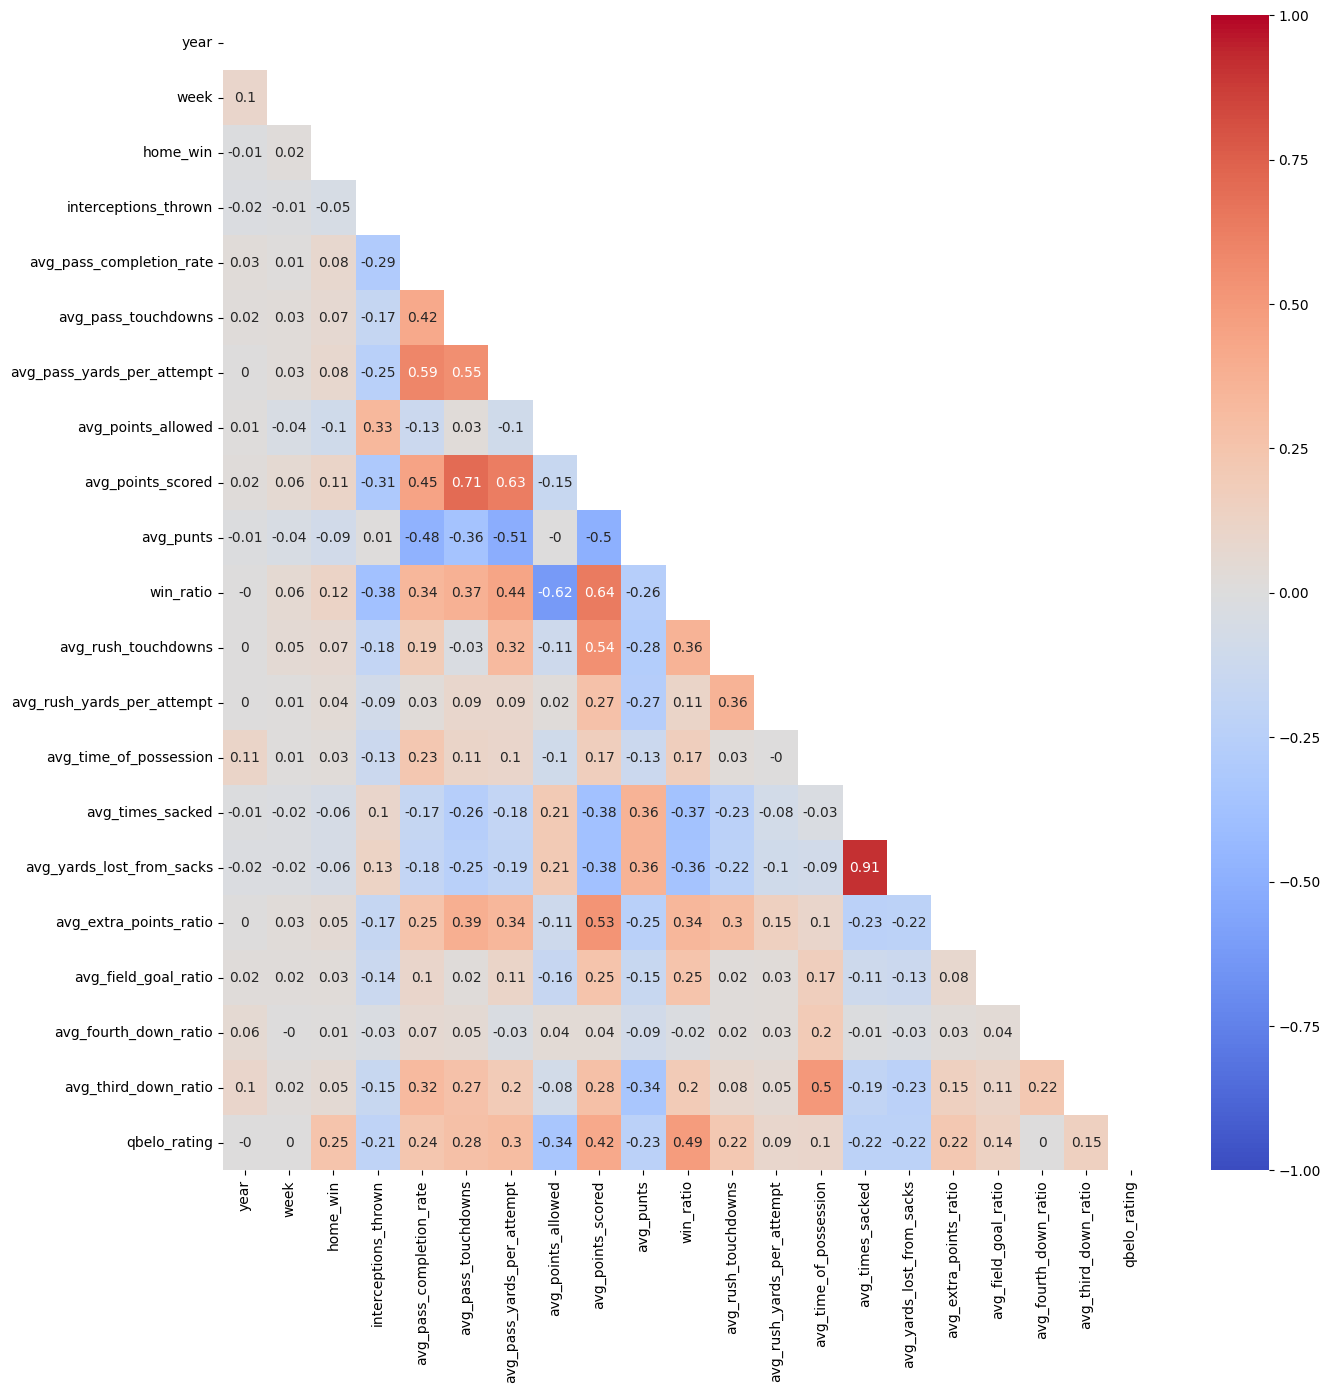

In [50]:
#Creating a correlation matrix
correlation_matrix = home_away_df.corr()

# Mask for upper-triangular
mask = np.triu(correlation_matrix)

plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix.round(2), annot=True, vmax=1, vmin=-1, cmap='coolwarm', mask=mask, center=0)
plt.show()

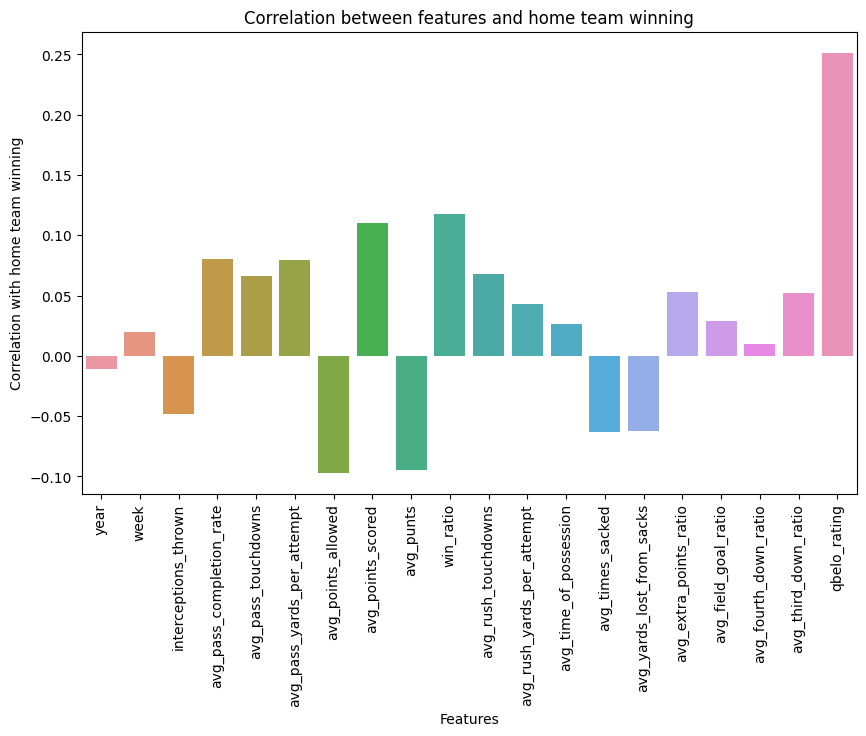

In [51]:
#Showing the correlation between the features and target variable
target_correlation = correlation_matrix['home_win'].drop('home_win')

plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation with home team winning')
plt.title('Correlation between features and home team winning')
plt.show()


In [52]:
target_correlation = correlation_matrix['home_win']

# Print the correlation values between features and target variable
print(target_correlation.abs().sort_values())


avg_fourth_down_ratio         0.010075
year                          0.010901
week                          0.020032
avg_time_of_possession        0.026550
avg_field_goal_ratio          0.029028
avg_rush_yards_per_attempt    0.042799
interceptions_thrown          0.048189
avg_third_down_ratio          0.052498
avg_extra_points_ratio        0.053328
avg_yards_lost_from_sacks     0.062325
avg_times_sacked              0.062827
avg_pass_touchdowns           0.066484
avg_rush_touchdowns           0.067909
avg_pass_yards_per_attempt    0.079518
avg_pass_completion_rate      0.080359
avg_punts                     0.094626
avg_points_allowed            0.096876
avg_points_scored             0.109856
win_ratio                     0.117985
qbelo_rating                  0.251443
home_win                      1.000000
Name: home_win, dtype: float64


Based on the results from the correlation matrix, I will drop our 4 least correlated features.

1. fourth down ratio
2. Year
3. week
4. time of possession
5. field goal ratio 

I will also drop avg yards lost from sacks because it is so strongly correlated to avg times sacked

In [53]:
x = home_away_df.drop(['home_win', 'home_abbr', 'away_abbr','year','week','avg_fourth_down_ratio', 'avg_field_goal_ratio', 'avg_time_of_possession', 'avg_yards_lost_from_sacks'], axis=1)
y = home_away_df['home_win']

x

,interceptions_thrown,avg_pass_completion_rate,avg_pass_touchdowns,avg_pass_yards_per_attempt,avg_points_allowed,avg_points_scored,avg_punts,win_ratio,avg_rush_touchdowns,avg_rush_yards_per_attempt,avg_times_sacked,avg_extra_points_ratio,avg_third_down_ratio,qbelo_rating
0,1.000000,-12.200000,-1.000000,2.500000,-6.000000,-21.000000,3.000000,-1.000000,-1.000000,-1.100000,2.000000,0.000000,-0.393939,-0.603903
1,-1.000000,4.100000,-1.000000,1.100000,7.000000,-10.000000,-2.000000,0.000000,0.000000,0.800000,1.000000,0.000000,-0.155556,0.426093
2,0.000000,11.600000,2.000000,5.900000,-21.000000,20.000000,-3.000000,1.000000,0.000000,-2.400000,-2.000000,0.000000,-0.048951,0.412120
3,-1.000000,-3.500000,1.000000,-1.200000,30.000000,4.000000,-4.000000,-1.000000,0.000000,0.600000,-2.000000,0.000000,0.267857,0.207510
4,1.000000,-11.700000,2.000000,0.300000,10.000000,11.000000,1.000000,0.000000,-1.000000,-0.700000,2.000000,0.000000,-0.071429,0.543928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,0.400000,-11.536667,-0.133333,-0.906667,6.333333,-5.066667,0.400000,-0.300000,0.033333,1.593333,2.133333,-0.033333,-0.026693,-0.349448
11394,0.347059,-4.490000,0.670588,0.370588,1.270588,1.558824,-0.752941,0.023529,-0.500000,-0.127647,0.105882,-0.093137,0.003409,0.071901
11395,-0.629412,3.378235,0.364706,-0.342941,-3.047059,5.788235,0.323529,0.364706,0.323529,0.249412,-0.735294,0.010294,0.036755,0.352534
11396,0.094118,1.829412,0.241176,0.127647,1.364706,-0.276471,-0.017647,-0.076471,0.058824,0.471765,-0.064706,0.180686,0.025011,-0.030402


In [54]:
#Setting up cross validation
from sklearn.model_selection import cross_val_score

X_remainder, X_test, y_remainder, y_test = train_test_split(x, y, test_size = 0.2,random_state=1)

#Through trial and error with a few different scaler types, the MaxAbsScaler performed the best. 
#However, in the absence of any scaler, the models were even more accurate, so none was used.

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaler.fit(X_remainder)
X_remainder = scaler.transform(X_remainder)
X_test = scaler.transform(X_test)

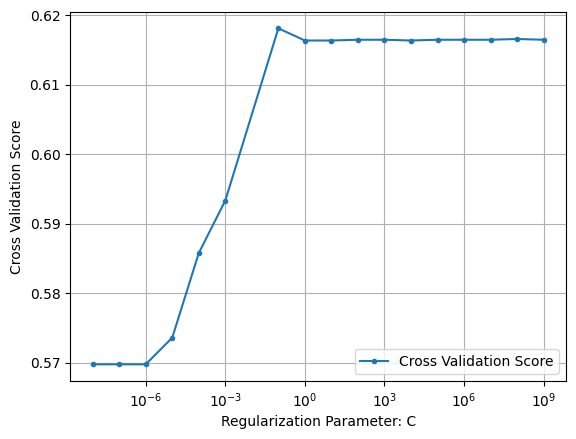

In [55]:
#Store the results
cross_validation_scores = []

C_range = np.array([.00000001,.0000001,.000001,.00001,.0001,.001,.1,\
                1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000])

#Running the models
for c in C_range:
    LR_model = LogisticRegression(C=c,max_iter=1000, random_state=1)
    
    # the cross validation score (mean of scores from all folds)
    cv_score = np.mean(cross_val_score(LR_model, X_remainder, y_remainder, cv = 5))
    
    cross_validation_scores.append(cv_score)

#Plotting results
plt.figure()
plt.plot(C_range, cross_validation_scores,label="Cross Validation Score",marker='.')
plt.legend()
plt.xscale("log")
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross Validation Score')
plt.grid()
plt.show();

In [56]:
index_highest_acc = np.argmax(cross_validation_scores)

print(f'best C value is {C_range[index_highest_acc]}')

best C value is 0.1


In [58]:
LR_model = LogisticRegression(C=0.1,max_iter=1000, random_state=1)
LR_model.fit(X_remainder,y_remainder)

print(LR_model.score(X_test,y_test))

0.6508771929824562


In [59]:
coefficients = LR_model.coef_
feature_names = x.columns

# Create a list of tuples containing feature names and their corresponding coefficients
coefficients_with_names = list(zip(feature_names, coefficients[0]))

# Sort the list based on the absolute value of coefficients in ascending order
sorted_coefficients = sorted(coefficients_with_names, key=lambda x: abs(x[1]))

# Print the sorted feature names and coefficients
for feature_name, coefficient in sorted_coefficients:
    print(f"{feature_name}: {coefficient}")


avg_points_scored: 0.0024237072892214387
avg_pass_completion_rate: 0.0029986003149757847
interceptions_thrown: -0.0037397820087956783
avg_points_allowed: -0.012444464533795429
avg_times_sacked: 0.012866183141939923
avg_pass_yards_per_attempt: -0.01357940932943227
avg_rush_yards_per_attempt: 0.024138725472684548
avg_rush_touchdowns: 0.0244236382622391
avg_pass_touchdowns: -0.03095215856638527
avg_extra_points_ratio: -0.044446165730199216
avg_punts: -0.06701523331543752
avg_third_down_ratio: 0.11914907362837764
win_ratio: -0.2067174851061513
qbelo_rating: 1.8256674617165212


In this new model, we have managed to drop 4 columns and obtain a slightly better accuracy score, that's great. In addition, it seems like the new feature (qbelo_rating) is the most predictive. Because this data is not scaled, it is difficult to determine the exact importance of other features because they are not necessarily on the same scale.

Let's try running some ensemble learning methods based on Log Reg, SVM and Decision Trees, and see if we can improve our model.
Here are the models we will try:
- Random Forest Classifier
- Ada Boost with Decision Tree
- Ada Boost with Log Reg
- XGBoost


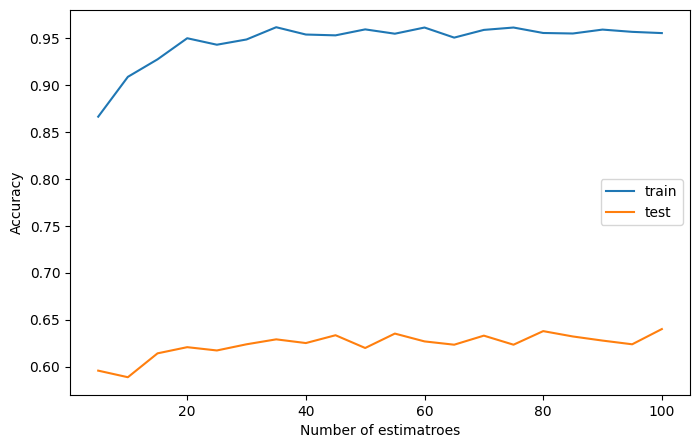

In [60]:
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=1)


train_scores = []
test_scores = []


n_range = range(5,101,5)

for n in n_range:
    
    # Instantiate the model
    RF_model = RandomForestClassifier(n_estimators=n, max_depth=15) # ran this for a few different depths and never got close to 65% acc
    
    # Fit
    RF_model.fit(X_train, y_train)
    
    # Scores
    train_acc = RF_model.score(X_train, y_train)
    test_acc = RF_model.score(X_test, y_test)
    
    train_scores.append(train_acc)
    test_scores.append(test_acc)

#Plotting results
plt.figure(figsize=(8,5))

plt.plot(n_range, train_scores, label = 'train')
plt.plot(n_range, test_scores, label = 'test')

plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')

plt.legend()
plt.show()

In [ ]:

# Find the maximum test score and its corresponding n value
max_test_score = max(test_scores)
max_n_value = n_range[test_scores.index(max_test_score)]

# Print the maximum test score and the associated n value
print("Maximum Test Score:", max_test_score)
print("Associated n value:", max_n_value)


Summary of results:

Max depth = 1
Maximum Test Score: 0.6118421052631579
Associated n value: 30

Max depth = 2
Maximum Test Score: 0.6267543859649123
Associated n value: 95

Max depth = 3
Maximum Test Score: 0.637719298245614
Associated n value: 45

Max depth = 4
Maximum Test Score: 0.6390350877192983
Associated n value: 30

Max depth = 5
Maximum Test Score: 0.6368421052631579
Associated n value: 25

Max depth = 6
Maximum Test Score: 0.637280701754386
Associated n value: 60

Max depth = 7
Maximum Test Score: 0.6381578947368421
Associated n value: 65

Max depth = 10
Maximum Test Score: 0.6425438596491229
Associated n value: 75

Max depth = 15
Maximum Test Score: 0.6434210526315789
Associated n value: 95

Despite improving the test accuracy as depth increasing, these models are vastly overfit. Unfortunately no model approaches the 65% accuracy from the original Log Reg model


## Ada Boost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
# Decision Tree base estimator

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)


n_est_range = list(range(1, 150, 5))
learning_rate_range = [0.1, 0.5, 1, 1.5]

results = pd.DataFrame()

for learning_rate in learning_rate_range:
    print(learning_rate, end=" ")
    for n_est in n_est_range:
        ada = AdaBoostClassifier(n_estimators=n_est, learning_rate=learning_rate)
        cv_score = np.mean(cross_val_score(ada, X_train, y_train, cv=5))
        
        results = results.append(
            {
                "learning_rate": learning_rate, 
                "n_estimators": n_est,
                "cv_score": cv_score
            }, ignore_index=True)
    
        print(n_est, end="\r")


plt.figure(figsize=(10, 7))
sns.lineplot(data=results, x="n_estimators", y="cv_score", hue="learning_rate")
plt.legend(title="Learning Rate")
plt.title("AdaBoost CV-scores with different number of estimators and learning rate")
plt.show()

In [ ]:
# Log Reg base estimator

import warnings
warnings.filterwarnings('ignore')

n_est_range = list(range(1, 150, 5))
learning_rate_range = [0.1, 0.5, 1, 1.5]

results = pd.DataFrame()

for learning_rate in learning_rate_range:
    print(learning_rate, end=" ")
    for n_est in n_est_range:
        ada = AdaBoostClassifier(base_estimator=LogisticRegression(), n_estimators=n_est, learning_rate=learning_rate)
        cv_score = np.mean(cross_val_score(ada, X_train, y_train, cv=5))
        
        results = results.append(
            {
                "learning_rate": learning_rate, 
                "n_estimators": n_est,
                "cv_score": cv_score
            }, ignore_index=True)
    
        print(n_est, end="\r")


plt.figure(figsize=(10, 7))
sns.lineplot(data=results, x="n_estimators", y="cv_score", hue="learning_rate")
plt.legend(title="Learning Rate")
plt.title("AdaBoost CV-scores with different number of estimators and learning rate")
plt.show()


- I won't bother running Ada Boost with SVM because it will most likely yield similar results to the log reg and compute time is fairly long.

## XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)


xgbc = XGBClassifier(n_jobs=-1)

parameters = {
    
    'n_estimators': np.arange(1, 100, 5),
    'max_depth': np.arange(1, 5)
}
grid_search_xgbc = GridSearchCV(xgbc, parameters, cv = 5, n_jobs = -1, verbose = 1)
grid_search_xgbc.fit(X_train, y_train)

# best score
print(f"best score: {grid_search_xgbc.best_score_}")

# best parameters 
print(f"best parameters: {grid_search_xgbc.best_params_}")

Despite attempting several ensemble learning techniques, it doesn't appear that any were more accurate than a log reg model. In the following notebook, final parameter tweaking and practical application of the model will be explored

In [124]:
#Dropping unnecessary cols
home_away_df = home_away_df.drop(['avg_fourth_down_ratio', 'avg_field_goal_ratio', 'avg_time_of_possession', 'avg_yards_lost_from_sacks'], axis=1)
home_away_df

,year,week,home_abbr,away_abbr,home_win,interceptions_thrown,avg_pass_completion_rate,avg_pass_touchdowns,avg_pass_yards_per_attempt,avg_points_allowed,avg_points_scored,avg_punts,win_ratio,avg_rush_touchdowns,avg_rush_yards_per_attempt,avg_times_sacked,avg_extra_points_ratio,avg_third_down_ratio,qbelo_rating
0,2011,2,car,gnb,0,1.000000,-12.200000,-1.000000,2.500000,-6.000000,-21.000000,3.000000,-1.000000,-1.000000,-1.100000,2.000000,0.000000,-0.393939,-0.603903
1,2011,2,clt,cle,0,-1.000000,4.100000,-1.000000,1.100000,7.000000,-10.000000,-2.000000,0.000000,0.000000,0.800000,1.000000,0.000000,-0.155556,0.426093
2,2011,2,det,kan,1,0.000000,11.600000,2.000000,5.900000,-21.000000,20.000000,-3.000000,1.000000,0.000000,-2.400000,-2.000000,0.000000,-0.048951,0.412120
3,2011,2,nor,chi,1,-1.000000,-3.500000,1.000000,-1.200000,30.000000,4.000000,-4.000000,-1.000000,0.000000,0.600000,-2.000000,0.000000,0.267857,0.207510
4,2011,2,nyj,jax,1,1.000000,-11.700000,2.000000,0.300000,10.000000,11.000000,1.000000,0.000000,-1.000000,-0.700000,2.000000,0.000000,-0.071429,0.543928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11393,2020,17,phi,was,0,0.400000,-11.536667,-0.133333,-0.906667,6.333333,-5.066667,0.400000,-0.300000,0.033333,1.593333,2.133333,-0.033333,-0.026693,-0.349448
11394,2020,19,buf,rav,1,0.347059,-4.490000,0.670588,0.370588,1.270588,1.558824,-0.752941,0.023529,-0.500000,-0.127647,0.105882,-0.093137,0.003409,0.071901
11395,2020,19,nor,tam,0,-0.629412,3.378235,0.364706,-0.342941,-3.047059,5.788235,0.323529,0.364706,0.323529,0.249412,-0.735294,0.010294,0.036755,0.352534
11396,2020,20,gnb,tam,0,0.094118,1.829412,0.241176,0.127647,1.364706,-0.276471,-0.017647,-0.076471,0.058824,0.471765,-0.064706,0.180686,0.025011,-0.030402


In [125]:
#Saving a copy of the finalized df for use in the next notebook
home_away_df.to_csv('final_df.csv', index=False)
